# Bicycle Rental Time Series Analysis





``` postgresql
BEGIN;

create temporary table t 
(
  Duration NUMERIC,
  Start_time TIMESTAMP,
  End_time TIMESTAMP,
  Start_Station NUMERIC,
  Start_Station_Name VARCHAR,
  End_Station NUMERIC,
  End_Station_Name VARCHAR,
  Bike VARCHAR,
  Member VARCHAR 
);

COPY t 
FROM '/tmp/2013Q4-capitalbikeshare-tripdata.csv' DELIMITER ',' CSV HEADER;

INSERT INTO rides(Duration, Start, Bike, Member)
SELECT Duration, Start_time, Bike, Member
FROM t;

drop table t;

COMMIT;

```


With the daily bike rental data inserted into my local PostgreSQL database, aggregating the data to yield monthly ridership was straight forward with the following query:

``` PostgreSQL
SELECT DATE_TRUNC('month', start) AS Month, COUNT(bike) AS Num_Rides  
FROM rides
GROUP BY Month;
```

With these monthly numbers, we can now move over to Python to do some time series analysis. I opted to save the table into a CSV file to keep things simple and not have to bring in additional libraries for connecting to the PostgreSQL database from Python.

For this project, I used pandas for additional data manipulation and statsmodels for time series modeling functionality. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing

In [8]:
bike = pd.read_csv('./data/rides_monthly_aggregate.csv', usecols = [1])
bike.set_index(pd.period_range('1/1/2013', freq='M', periods=84), inplace = True)

bike.head()

,num_rides
2013-01,124989
2013-02,110102
2013-03,157366
2013-04,236442
2013-05,250463


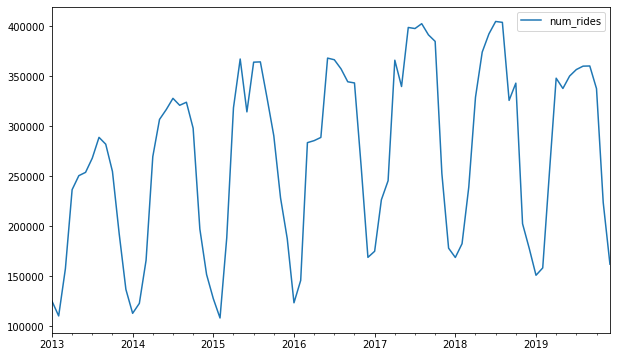

In [9]:
bike.plot(figsize = (10,6))

In [10]:
fit_hw = ExponentialSmoothing(bike, seasonal_periods = 12, trend = 'add', seasonal = 'add').fit()

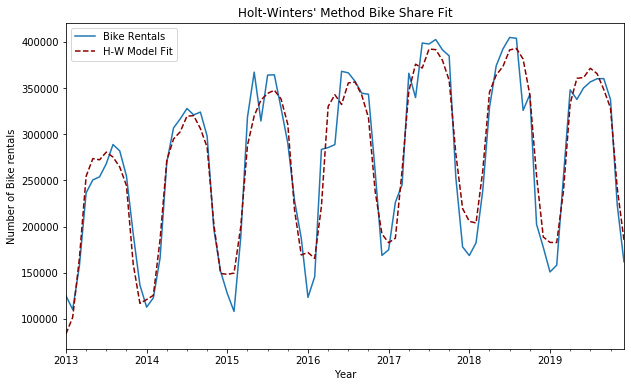

In [11]:
bike_plot = bike.plot(figsize = (10,6), title = "Holt-Winters' Method Bike Share Fit")
bike_plot.set_ylabel("Number of Bike rentals")
bike_plot.set_xlabel("Year")

fit_hw.fittedvalues.plot(ax = bike_plot, style = '--', color = 'DarkRed')
bike_plot.legend(['Bike Rentals', 'H-W Model Fit'])

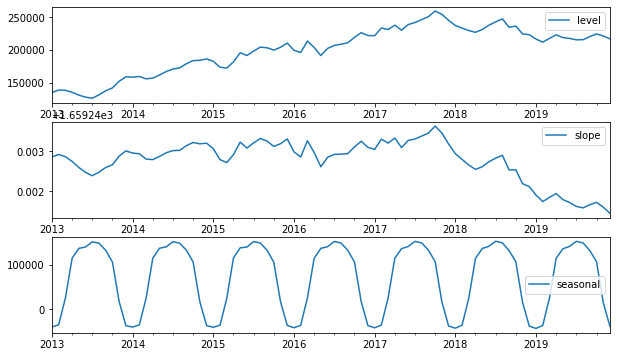

In [12]:
states_decomp = pd.DataFrame(np.c_[fit_hw.level, fit_hw.slope, fit_hw.season], columns=['level','slope','seasonal'], index=bike.index)

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10,10))
states_decomp[['level']].plot(ax = ax1)
states_decomp[['slope']].plot(ax = ax2)
states_decomp[['seasonal']].plot(ax = ax3)